# Condition Robustness
We want to analyse the robustness with the updated error bounds considering the supremum of the derivative. We do this for the **reversed condition** and **condition**.

For the the reversed condition we also try to find **threshold for classification** (classifying wether a matrix is singular or not)

In [1]:
import numpy as np
from numpy.linalg import matrix_rank, svd
import sys
sys.path.append('../')
from test_data import experiment_data,add_noise,create_data_2d
import pysindy as ps
import matplotlib.pyplot as plt
from error_bounds import *

## Condition $\frac{\sigma_1}{\sigma_n}$

We consider the condition 
\begin{equation}
    k: S \rightarrow \mathbb{R}, k(A) = \frac{\sigma_1}{\sigma_n}
\end{equation}
where  $m\geq n, S=\{A\in\mathbb{R}^{m\times n}|A\text{ has full rank }n\}$. Because of the mean value theorem we now $|k({\tilde {A}})-k(A)| \leq  {\|{\tilde {A}}-A\|}\sup_{A'\in[A,\tilde{A}]} \|Dk(A')\|_F $. This implies for $\sigma_n-\|E\|_F>0$
$$    | \frac{\sigma_1(A+E)}{\sigma_n(A+E)} - \frac{\sigma_1(A)}{\sigma_n(A)} | 
    \leq \frac{\|E\|_F}{\sigma_n-\|E\|_F}\sqrt{ 1+\frac{\sigma_1+\|E\|_F}{\sigma_n-\|E\|_F}^2 }$$

This bound is only valid of $\sigma_n - \|E\|_F >0$ which might not be the case for $\sigma_n$  small.

In [2]:
# This calculates the above given bound
"""
sv_max: maximal singular value
sv_min: minimal singular value
eps: bound for Frobenius norm of noise matrix: ||E||_F <= eps
"""
def error_bound_condition(omax,omin,eps):
    #If this does not hold the error bound is invalid
    if omin-eps>0:
        return eps/(omin-eps)*np.sqrt(1+((omax+eps)/(omin-eps))**2)
    else:
        return np.infty

In [3]:
rows,cols = 10,3 #let rows be more than columns
min_value,max_value = -5,1
matrix = np.random.uniform(min_value, max_value, size=(rows, cols))
# Set col 2 equal to col 1
alpha = np.random.rand()
print(alpha)
matrix[:,0] = alpha*matrix[:,2]
print(matrix)

sv = svd(matrix, compute_uv=False)
sv_max = sv[0]
sv_min = sv[-1]
print(f"matrix shape: {matrix.shape}, rank: {matrix_rank(matrix)}" )
print(f"Singular values : {sv}" )
print(f"Condtion big/smallest singular value: {sv[0]/sv[-1]}")
print(f"Bound: {error_bound_condition(sv_max,sv_min,0)}")

0.7718763447817933
[[-2.69638120e+00 -2.74336506e+00 -3.49328130e+00]
 [-3.56753355e+00 -3.26517080e-03 -4.62189777e+00]
 [-1.30148108e+00 -2.75344476e+00 -1.68612640e+00]
 [-2.79176260e+00 -5.26005648e-01 -3.61685213e+00]
 [-2.06647806e-01 -2.02929269e+00 -2.67721387e-01]
 [-1.18929421e+00  9.44056195e-01 -1.54078333e+00]
 [-2.06137942e+00 -3.72726753e+00 -2.67060836e+00]
 [-3.54194778e+00 -2.78553469e+00 -4.58875026e+00]
 [-2.48771650e+00 -2.38457332e+00 -3.22294694e+00]
 [ 3.65388067e-01 -1.71794630e+00  4.73376428e-01]]
matrix shape: (10, 3), rank: 2
Singular values : [1.30911942e+01 4.90902250e+00 1.49312346e-15]
Condtion big/smallest singular value: 8767656836251101.0
Bound: 0.0


In [4]:
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
print("Noise level \t matrix rank \t sv \t \t \t \t \t  ratio \t bound  \t diff")
differences =[]
bounds =[]
for target_noise in noise_levels:
    var = target_noise * np.sqrt(np.mean(np.square(matrix)))
    noise = np.random.normal(0, var, size=matrix.shape)
    matrix_noise = matrix+noise
    sv = svd(matrix_noise, compute_uv=False)
    ratio = sv[0]/sv[-1]
    bound=error_bound_condition(sv_max,sv_min,np.linalg.norm(noise))
    differences.append(np.abs(ratio-sv_max/sv_min))
    bounds.append(bound)
    print(f" {target_noise}\t \t {matrix_rank(matrix_noise)} \t \t {sv} \t {ratio:3.3e}  \t {bound:3.3e}\t {np.abs(ratio-sv_max/sv_min):3.3e}")

Noise level 	 matrix rank 	 sv 	 	 	 	 	  ratio 	 bound  	 diff
 0	 	 2 	 	 [1.30911942e+01 4.90902250e+00 1.49312346e-15] 	 8.768e+15  	 0.000e+00	 0.000e+00
 1e-10	 	 3 	 	 [1.30911942e+01 4.90902250e+00 7.91606747e-10] 	 1.654e+10  	 inf	 8.768e+15
 1e-09	 	 3 	 	 [1.30911942e+01 4.90902250e+00 5.09173195e-09] 	 2.571e+09  	 inf	 8.768e+15
 1e-08	 	 3 	 	 [1.30911941e+01 4.90902250e+00 7.50006234e-08] 	 1.745e+08  	 inf	 8.768e+15
 1e-07	 	 3 	 	 [1.30911944e+01 4.90902244e+00 6.32119373e-07] 	 2.071e+07  	 inf	 8.768e+15
 1e-06	 	 3 	 	 [1.30911962e+01 4.90902301e+00 4.88061832e-06] 	 2.682e+06  	 inf	 8.768e+15
 1e-05	 	 3 	 	 [1.30911940e+01 4.90903047e+00 9.10092323e-05] 	 1.438e+05  	 inf	 8.768e+15
 0.0001	 	 3 	 	 [1.30913928e+01 4.90871155e+00 5.08892633e-04] 	 2.573e+04  	 inf	 8.768e+15
 0.001	 	 3 	 	 [1.30894625e+01 4.90923761e+00 7.85035770e-03] 	 1.667e+03  	 inf	 8.768e+15
 0.01	 	 3 	 	 [13.11618028  4.97030837  0.04172114] 	 3.144e+02  	 inf	 8.768e+15
 0.1	 	 3 	 	

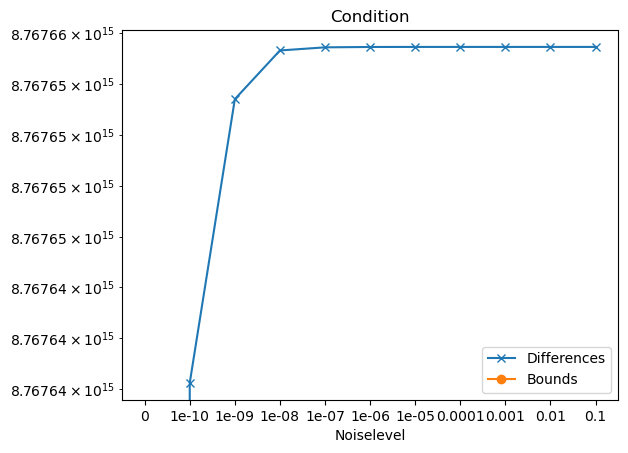

In [5]:
plt.title("Condition")
plt.plot(differences,marker='x',label="Differences")
plt.plot(bounds,marker='o',label="Bounds")
plt.xticks(np.arange(len(noise_levels)),noise_levels)
plt.yscale('log')
plt.xlabel('Noiselevel')
plt.legend()

Since for matrix with not full rank the bound is very high, I want to test the deviation for the same noise level

In [7]:
trials=10
noise_level=1e-9
differences=[]
bounds=[]
print(f"Noise level:  {noise_level}, Number trials: {trials}, True ratio: {sv_max/sv_min}")
print("Trial \t matrix rank \t sv \t \t \t \t \t  ratio \t  bound \t difference")
for trial in range(trials):
    var = noise_level * np.sqrt(np.mean(np.square(matrix)))
    noise = np.random.normal(0, var, size=matrix.shape)
    matrix_noise = matrix+noise
    sv = svd(matrix_noise, compute_uv=False)
    ratio=sv[0]/sv[-1]
    bound = error_bound_condition(sv_max,sv_min,np.linalg.norm(noise))
    bounds.append(bound)
    differences.append(np.abs(ratio-sv_max/sv_min))
    print(f" {trial}\t \t {matrix_rank(matrix_noise)} \t {sv}\t  {ratio:3.3e}   \t {bound:3.3e} \t  {np.abs(ratio-sv_max/sv_min):3.3e}")

Noise level:  1e-09, Number trials: 10, True ratio: 8767656836251101.0
Trial 	 matrix rank 	 sv 	 	 	 	 	  ratio 	  bound 	 difference
 0	 	 3 	 [1.30911942e+01 4.90902250e+00 7.90896900e-09]	  1.655e+09   	 inf 	  8.768e+15
 1	 	 3 	 [1.30911942e+01 4.90902250e+00 6.94560269e-09]	  1.885e+09   	 inf 	  8.768e+15
 2	 	 3 	 [1.30911942e+01 4.90902251e+00 4.54018078e-09]	  2.883e+09   	 inf 	  8.768e+15
 3	 	 3 	 [1.30911942e+01 4.90902251e+00 5.62213268e-09]	  2.329e+09   	 inf 	  8.768e+15
 4	 	 3 	 [1.30911942e+01 4.90902251e+00 8.68395866e-09]	  1.508e+09   	 inf 	  8.768e+15
 5	 	 3 	 [1.30911942e+01 4.90902250e+00 6.77999086e-09]	  1.931e+09   	 inf 	  8.768e+15
 6	 	 3 	 [1.30911942e+01 4.90902251e+00 7.62585565e-09]	  1.717e+09   	 inf 	  8.768e+15
 7	 	 3 	 [1.30911942e+01 4.90902250e+00 8.62282563e-09]	  1.518e+09   	 inf 	  8.768e+15
 8	 	 3 	 [1.30911942e+01 4.90902250e+00 8.87304342e-09]	  1.475e+09   	 inf 	  8.768e+15
 9	 	 3 	 [1.30911942e+01 4.90902250e+00 6.49617656e-09

## Reversed condition $\frac{\sigma_n}{\sigma_1}$

We consider the function reversed condition 
\begin{equation}
    r: \mathbb{R}^{m\times n} / \{0\} \rightarrow \mathbb{R}, r(A) = \frac{\sigma_n}{\sigma_r}
\end{equation}
where  $m\geq n$. Because of the mean value theorem we know $|r({\tilde {A}})-r(A)| \leq  {\|{\tilde {A}}-A\|}\sup_{A'\in[A,\tilde{A}]} \|Dr(A')\|_F $. This implies for $\sigma_1-\|E\|_F>0$
$$    | \frac{\sigma_n(A+E)}{\sigma_1(A+E)} - \frac{\sigma_n(A)}{\sigma_1(A)} | 
    \leq \frac{\|E\|_F}{\sigma_1-\|E\|_F}\sqrt{ 1+\frac{\sigma_n+\|E\|_F}{\sigma_1-\|E\|_F}^2 }$$
Can we maybe also found a lower bound for this?

### Reversed condition: Error bounds

In [8]:
# This calculates the above given bound
"""
sv_max: maximal singular value
sv_min: minimal singular value
eps: bound for Frobenius norm of noise matrix: ||E||_F <= eps
"""
def error_bound_rev_condition(omax,omin,eps):
    assert(omax-eps>0)
    return eps/(omax-eps)*np.sqrt(1+((omin+eps)/(omax-eps))**2)


In [9]:
rows,cols = 10,3 #let rows be more than columns
min_value,max_value = -5,1
matrix = np.random.uniform(min_value, max_value, size=(rows, cols))
# Set col 2 equal to col 1
alpha = np.random.rand()
print(alpha)
matrix[:,0] = alpha*matrix[:,2]
print(matrix)
sv = svd(matrix, compute_uv=False)
sv_max = sv[0]
sv_min = sv[-1]
print(f"matrix shape: {matrix.shape}, rank: {matrix_rank(matrix)}" )
print(f"Singular values : {sv}" )
print(f"Condtion big/smallest singular value: {sv[-1]/sv[0]}")
print(f"Bound: {error_bound_condition(sv_max,sv_min,0)}")

0.28297690131445064
[[-0.12791415 -1.32710044 -0.45203034]
 [-0.32778609  0.50306095 -1.15834929]
 [-1.23383334  0.48771008 -4.36019101]
 [-0.82273506 -2.20539569 -2.90742834]
 [-0.32599758  0.92627441 -1.15202893]
 [-0.33526895 -3.84687529 -1.18479265]
 [-0.80992152  0.01773342 -2.8621471 ]
 [-1.05391907 -4.49715049 -3.72439965]
 [-1.12075236 -4.81959524 -3.96057894]
 [-1.32018923 -3.68129624 -4.6653604 ]]
matrix shape: (10, 3), rank: 2
Singular values : [1.23695515e+01 5.03341801e+00 7.13138709e-16]
Condtion big/smallest singular value: 5.765275392224467e-17
Bound: 0.0


In [10]:
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
print("Noise level \t matrix rank \t sv \t \t \t \t \t  ratio \t bound  \t diff")
differences =[]
bounds =[]
for target_noise in noise_levels:
    var = target_noise * np.sqrt(np.mean(np.square(matrix)))
    noise = np.random.normal(0, var, size=matrix.shape)
    matrix_noise = matrix+noise
    sv = svd(matrix_noise, compute_uv=False)
    ratio = sv[-1]/sv[0]
    bound=error_bound_rev_condition(sv_max,sv_min,np.linalg.norm(noise))
    differences.append(np.abs(ratio-sv_min/sv_max))
    bounds.append(bound)
    print(f" {target_noise}\t \t {matrix_rank(matrix_noise)} \t \t {sv} \t {ratio:3.3e}  \t {bound:3.3e}\t {np.abs(ratio-sv_min/sv_max):3.3e}")

Noise level 	 matrix rank 	 sv 	 	 	 	 	  ratio 	 bound  	 diff
 0	 	 2 	 	 [1.23695515e+01 5.03341801e+00 7.13138709e-16] 	 5.765e-17  	 0.000e+00	 0.000e+00
 1e-10	 	 3 	 	 [1.23695515e+01 5.03341801e+00 4.59175438e-10] 	 3.712e-11  	 1.080e-10	 3.712e-11
 1e-09	 	 3 	 	 [1.23695515e+01 5.03341801e+00 3.87737128e-09] 	 3.135e-10  	 1.061e-09	 3.135e-10
 1e-08	 	 3 	 	 [1.23695515e+01 5.03341799e+00 6.72764406e-08] 	 5.439e-09  	 1.076e-08	 5.439e-09
 1e-07	 	 3 	 	 [1.23695518e+01 5.03341772e+00 7.71908358e-07] 	 6.240e-08  	 1.180e-07	 6.240e-08
 1e-06	 	 3 	 	 [1.23695534e+01 5.03342100e+00 4.43593246e-06] 	 3.586e-07  	 9.470e-07	 3.586e-07
 1e-05	 	 3 	 	 [1.23695458e+01 5.03342093e+00 5.39080069e-05] 	 4.358e-06  	 9.885e-06	 4.358e-06
 0.0001	 	 3 	 	 [1.23695496e+01 5.03344174e+00 6.01650824e-04] 	 4.864e-05  	 1.117e-04	 4.864e-05
 0.001	 	 3 	 	 [1.23715931e+01 5.03545861e+00 6.76684335e-03] 	 5.470e-04  	 1.071e-03	 5.470e-04
 0.01	 	 3 	 	 [12.36328229  5.05724493  0.02271

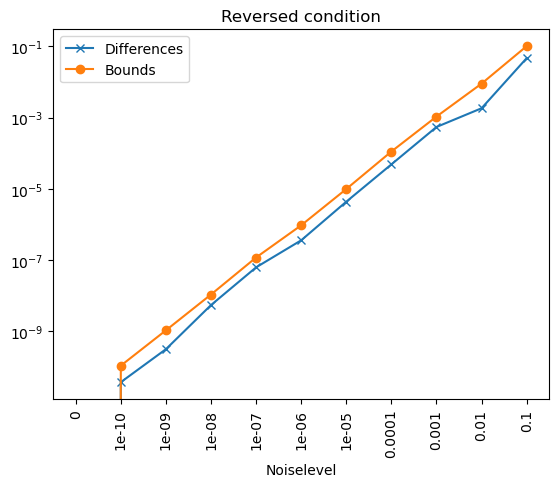

In [11]:
plt.title("Reversed condition")
plt.plot(differences,marker='x',label="Differences")
plt.plot(bounds,marker='o',label="Bounds")
plt.xticks(np.arange(len(noise_levels)),noise_levels,rotation=90)
plt.yscale('log')
plt.xlabel('Noiselevel')
plt.legend()

### Reversed condition: Threshold

If a matrix $A$ is **singular** ($\sigma_n=0$) we have
$$ \frac{\tilde{\sigma}_n}{\tilde{\sigma}_1} \leq \frac{\epsilon}{C-\epsilon}\sqrt{ 1+\frac{\epsilon}{C-\epsilon}^2 }$$
for $C\leq \sigma_1$ and $\epsilon \geq \|E\|_F$.<br>
If a matrix $A$ is **non singular** ($\sigma_n>0$) we have
$$\frac{\tilde{\sigma}_n}{\tilde{\sigma}_1} \geq \frac{\sigma_n-\epsilon}{\sigma_1+\epsilon} \geq \frac{C_2-\epsilon}{C_1+\epsilon}$$
for $C_2 \leq\sigma_n,  \sigma_1 \leq C_1$

In [16]:
"""
This function should upper bound the reversed condition for singular matrices 
where on>C2>0
 C1:  lower bound of biggest singular value: C <= o_max
 eps: lower bound for frobenius norm of error matrix |E|_F <= eps
"""
def upper_bound_singular_matrix(C,eps):
    if C-eps<=0:
        print(f"Error is too big C<eps with C = {C:.3e}, eps = {eps:.3e}: no upper bound can be calculated")
        return 1.0
    bound= eps/(C-eps)*np.sqrt(1+(eps/(C-eps))**2) 
    bound = min(bound, 1.0) # o_min/o_max <= 1 in all cases
    return bound

"""
This function should lower bound the reversed condition for nonsingular matrices 
where on>C2>0
C1: upper bound for o1 < C1
C2: lower bound for on > C2 > 0
eps: lower obund for frobenius norm of error matrix |E|_F <= eps
The question is how to choose C2?-> boils down to the original problem
"""
def lower_bound_nonsingular_matrix(C1,C2,eps):
    bound= (C2-eps)/(C1+eps)
    bound = max(bound,1e-10)
    return bound

In [17]:
rows,cols = 10,3 #let rows be more than columns
min_value,max_value = -1,2
matrix = np.random.uniform(min_value, max_value, size=(rows, cols))
# Set col 2 equal to col 1
alpha = np.random.rand()
print(alpha)
#matrix[:,0] = alpha*matrix[:,2]
print(matrix)
sv = svd(matrix, compute_uv=False)
sv_max,sv_min = sv[0],sv[-1]
print(f"matrix shape: {matrix.shape}, rank: {matrix_rank(matrix)}" )
print(f"Singular values : {sv}" )
print(f"Smallest/Biggest singular value: {sv[-1]/sv[0]}")

0.9167193010372787
[[ 0.85674056 -0.47321164 -0.51259564]
 [ 1.07786848 -0.20856464 -0.94709002]
 [ 1.30306356  0.55076257 -0.04649238]
 [ 1.10937839  0.48471418  1.79901064]
 [ 1.23339393  1.56562003  0.88486906]
 [-0.945757    1.6251072  -0.09942606]
 [ 0.73039763  1.42902627  0.71701854]
 [ 0.78835982  0.5343895   0.20395481]
 [ 1.4679212   1.68288144 -0.84305183]
 [ 1.95369057  1.10459758  0.52387693]]
matrix shape: (10, 3), rank: 3
Singular values : [4.61808667 2.59655009 2.30390767]
Smallest/Biggest singular value: 0.4988879243484417


In [18]:
# C values for second threshold
C=sv_max #<=sv_max
C1=sv_max#9 #>=sv_max
C2=1e-8#<=sv_min

In [20]:
noise_levels = [10**(-10+i) for i in range(0,9)]
print("Noise level \t ratio \t \t Upper bound \t Lower bound")
ratios =[]
upper_bounds =[]
lower_bounds =[]
for target_noise in noise_levels:
    var = target_noise * np.sqrt(np.mean(np.square(matrix)))
    noise = np.random.normal(0, var, size=matrix.shape)
    matrix_noise = matrix+noise
    sv = svd(matrix_noise, compute_uv=False)
    ratio = sv[-1]/sv[0]
    # Do an educated guess for C and C1
    #C=sv[0] -np.linalg.norm(noise) 
    #C2=sv[-1] + np.linalg.norm(noise) 
    
    ratios.append(ratio)
    upper_bound = upper_bound_singular_matrix(C,np.linalg.norm(noise))
    upper_bounds.append(upper_bound)
    lower_bound = lower_bound_nonsingular_matrix(C1,C2,np.linalg.norm(noise))
    lower_bounds.append(lower_bound)
    print(f" {target_noise}\t \t {ratio:3.3e}  \t {upper_bound:3.3e} \t {lower_bound:3.3e}")

Noise level 	 ratio 	 	 Upper bound 	 Lower bound
 1e-10	 	 4.989e-01  	 1.610e-10 	 2.004e-09
 1e-09	 	 4.989e-01  	 1.418e-09 	 7.477e-10
 1e-08	 	 4.989e-01  	 1.176e-08 	 1.000e-10
 1e-07	 	 4.989e-01  	 1.086e-07 	 1.000e-10
 1e-06	 	 4.989e-01  	 1.083e-06 	 1.000e-10
 1e-05	 	 4.989e-01  	 8.378e-06 	 1.000e-10
 0.0001	 	 4.989e-01  	 9.121e-05 	 1.000e-10
 0.001	 	 4.987e-01  	 1.380e-03 	 1.000e-10
 0.01	 	 5.015e-01  	 1.258e-02 	 1.000e-10


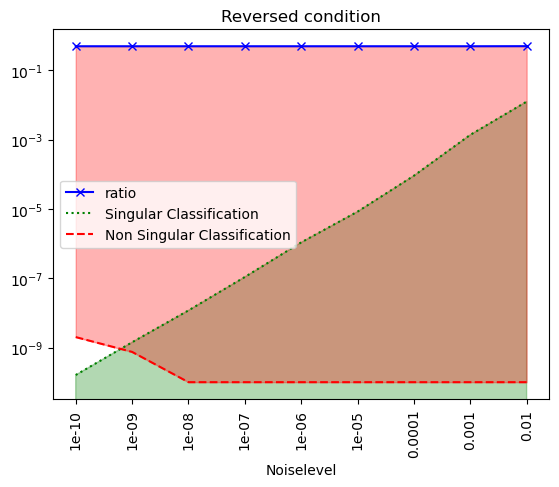

In [21]:
plt.title("Reversed condition")
plt.plot(ratios,marker='x',label="ratio",color='blue')
plt.plot(upper_bounds,':',label="Singular Classification",color='green')
plt.plot(lower_bounds,'--',label="Non Singular Classification",color='red')
plt.fill_between(np.arange(len(noise_levels)), upper_bounds,color='green', alpha=0.3)
plt.fill_between(np.arange(len(noise_levels)), lower_bounds, y2=np.max(ratios), color='red', alpha=0.3)
plt.xticks(np.arange(len(noise_levels)),noise_levels,rotation=90)
plt.yscale('log')
plt.xlabel('Noiselevel')
plt.legend()

### Reversed Condition: Threshold on concrete data

Denote the singular value of $\tilde{G}=G+E$ by  $\tilde{\sigma}_n$ where $G=(u|u_x)$. Furthermore, let $E \geq \|G-\tilde{G}\|_F$.

If the PDE is **non unique**, then $G$ is singular ($\sigma_n=0$) and we have
$$ \frac{\tilde{\sigma}_n}{\tilde{\sigma}_1} \leq \frac{E}{C-E}\sqrt{ 1+\frac{E}{C-E}^2 }$$
for $C\leq \sigma_1$.

If the PDE is **unique**, then $G$ is non singular ($\sigma_n>0$) and we have
$$\frac{\tilde{\sigma}_n}{\tilde{\sigma}_1} \geq \frac{\sigma_n-E}{\sigma_1+E} \geq \frac{C_2-E}{C_1+E}$$
for $0 <C_2 \leq \sigma_n,  \sigma_1 \leq C_1$. Note we need to have a valid approximation for a reasonable choice for $C_2$.

Note, here $E$ is the upper bound on the error caused by finite differences
$$E = \sqrt{ m(C_m \frac{\|u-\tilde{u}\|_{\infty}}{h} + h^{order} M C_a)^2 + \|u-\tilde{u}\|_2^2 }$$
However, since in practice we won't know all of these constands we can buest guess $E$ by guessing the maximal error $\epsilon \geq \|u-\tilde{u}\|_{\infty}$ and choosing
$$E =\frac{\epsilon}{h} + h^{order} $$

In [22]:
"""Threshold if values are beneath classify as non unique PDE
E: upper bound on the frobenius  |g-g_noise|_frobenius <=E where g =(u|u_x|...)
C: lower bound of biggest singular value: C <= o_max
"""
def calc_threshold_nonuniq(E,C):
    T = upper_bound_singular_matrix(C,E)
    return T
"""Threshold if values are above classify as unique PDE
E: upper bound on the frobenius  |g-g_noise|_frobenius <=E where g =(u|u_x|...)
C1: upper bound of biggest singular value: C1 => o_max
C2: upper bound of biggest singular value: C2 <= o_max
"""
def calc_threshold_uniq(C1,C2,E):
    T = lower_bound_nonsingular_matrix(C1,C2,E)
    return T

In [23]:
n_samples=100
T,X,t,x = create_data_2d(T_start=0, T_end=1, L_x_start=-2,L_x_end=3, N_t=n_samples, N_x=n_samples)
a=np.random.randn()*1e-6
b=np.random.randn()*1e-3
C=0.1
"""
u = np.cos(X-a*T)*C
ux = -np.sin(X-a*T)*C
uxx = -np.cos(X-a*T)*C
uxxx = np.sin(X-a*T)*C
ut = a*np.sin(X-a*T)*C


u=(X+b*T)*np.exp(a*T)
ux = np.exp(a*T)
uxx= 1
uxxx= 0
ut= b*np.exp(a*T) + a*(X*+b*T)*np.exp(a*T) #bux + aut
"""

u = np.exp(X-a*T)
ux = u
uxx = u
uxxx = u
ut = -a*u

dx=x[1]-x[0]

In [24]:
u_flat, ux_flat = u.flatten(), ux.flatten()
true_g = np.concatenate([u_flat.reshape(len(u_flat),1), ux_flat.reshape(len(ux_flat),1)], axis=1)
sv = svd(true_g, compute_uv=False)
sv_max,sv_min=sv[0],sv[-1]
print(f"M: {np.max(u)}")
print(f"Singular values of g: {sv_max,sv_min}")
print(f"sv_max/sv_min: {sv_min/sv_max:3.3e}")

M: 20.08555387075592
Singular values of g: (916.3935794187613, 3.369013117621679e-13)
sv_max/sv_min: 3.676e-16


In [25]:
# Choose C,C1,C2
C=sv_max #<=sv_max
C1=sv_max+4 #>=sv_max
C2=1e-02#<=sv_min -> Essentially this boils down to the original problem  of knowing when sv_min is too small to classify the PDE as unique
print(f"For Non-Uniquness: \t \t C = {C:.3e} <= {sv_max:.3e} = sv_max")
print(f"For Uniqueness: \t C1 = {C1:.3e} >= {sv_max:.3e} = sv_max")
print(f"\t \t \t C2 = {C2:.3e} <= {sv_min:.3e} = sv_min")

For Non-Uniquness: 	 	 C = 9.164e+02 <= 9.164e+02 = sv_max
For Uniqueness: 	 C1 = 9.204e+02 >= 9.164e+02 = sv_max
	 	 	 C2 = 1.000e-02 <= 3.369e-13 = sv_min


0.0
order 	 singular values 	 ratio 	 Threshold uniq 	 Threshold non-uniq 
1 	 [926.01242505   6.75034494] 	 7.290e-03 	 1.000e-10 	 1.844e-02
2 	 [9.16533655e+02 1.67953153e-01] 	 1.832e-04 	 1.000e-10 	 3.376e-04
3 	 [9.16388561e+02 3.99734482e-03] 	 4.362e-06 	 1.007e-06 	 9.901e-06
4 	 [9.16393458e+02 1.54851092e-04] 	 1.690e-07 	 1.056e-05 	 3.037e-07
5 	 [9.16393579e+02 7.48577321e-06] 	 8.169e-09 	 1.085e-05 	 1.155e-08
6 	 [9.16393579e+02 3.00422789e-07] 	 3.278e-10 	 1.086e-05 	 4.682e-10
7 	 [9.16393579e+02 1.21677118e-08] 	 1.328e-11 	 1.086e-05 	 1.998e-11
8 	 [9.16393579e+02 5.67817352e-10] 	 6.196e-13 	 1.086e-05 	 9.219e-13
9 	 [9.16393579e+02 6.60478079e-11] 	 7.207e-14 	 1.086e-05 	 1.056e-13


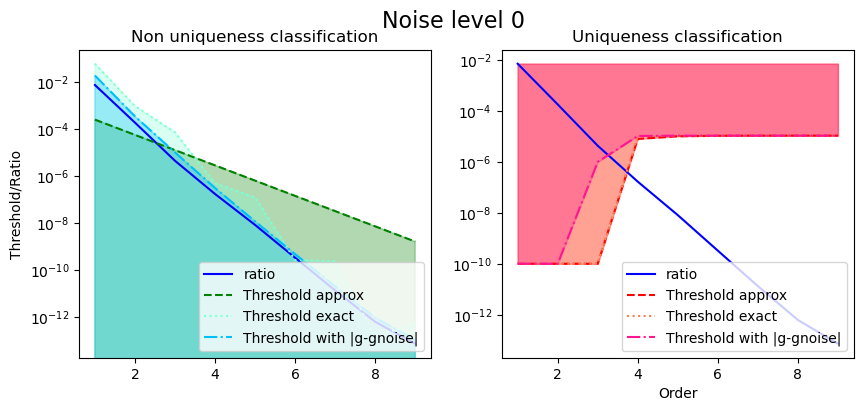

6.467503921411084e-08
order 	 singular values 	 ratio 	 Threshold uniq 	 Threshold non-uniq 
1 	 [926.01242504   6.75034496] 	 7.290e-03 	 1.000e-10 	 1.844e-02
2 	 [9.16533655e+02 1.67953193e-01] 	 1.832e-04 	 1.000e-10 	 3.376e-04
3 	 [9.16388561e+02 3.99738310e-03] 	 4.362e-06 	 1.007e-06 	 9.901e-06
4 	 [9.16393458e+02 1.54910414e-04] 	 1.690e-07 	 1.056e-05 	 3.038e-07
5 	 [9.16393579e+02 7.69407235e-06] 	 8.396e-09 	 1.085e-05 	 1.187e-08
6 	 [9.16393579e+02 1.91988509e-06] 	 2.095e-09 	 1.086e-05 	 2.964e-09
7 	 [9.16393579e+02 2.82857557e-06] 	 3.087e-09 	 1.086e-05 	 4.360e-09
8 	 [9.16393579e+02 4.47470660e-06] 	 4.883e-09 	 1.086e-05 	 6.905e-09
9 	 [9.16393579e+02 7.55470376e-06] 	 8.244e-09 	 1.085e-05 	 1.166e-08


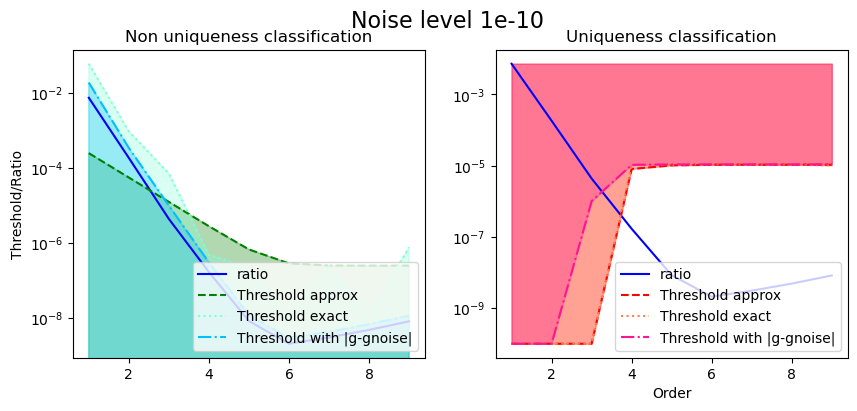

6.454039387053386e-07
order 	 singular values 	 ratio 	 Threshold uniq 	 Threshold non-uniq 
1 	 [926.01242506   6.75034495] 	 7.290e-03 	 1.000e-10 	 1.844e-02
2 	 [9.16533655e+02 1.67953187e-01] 	 1.832e-04 	 1.000e-10 	 3.376e-04
3 	 [9.16388561e+02 3.99743749e-03] 	 4.362e-06 	 1.007e-06 	 9.901e-06
4 	 [9.16393458e+02 1.55416977e-04] 	 1.696e-07 	 1.056e-05 	 3.044e-07
5 	 [9.16393579e+02 1.79922965e-05] 	 1.963e-08 	 1.084e-05 	 2.765e-08
6 	 [9.16393579e+02 2.09360126e-05] 	 2.285e-08 	 1.083e-05 	 3.231e-08
7 	 [9.16393580e+02 3.11885765e-05] 	 3.403e-08 	 1.082e-05 	 4.808e-08
8 	 [9.16393580e+02 4.84628314e-05] 	 5.288e-08 	 1.079e-05 	 7.479e-08
9 	 [9.16393581e+02 7.95985053e-05] 	 8.686e-08 	 1.074e-05 	 1.228e-07


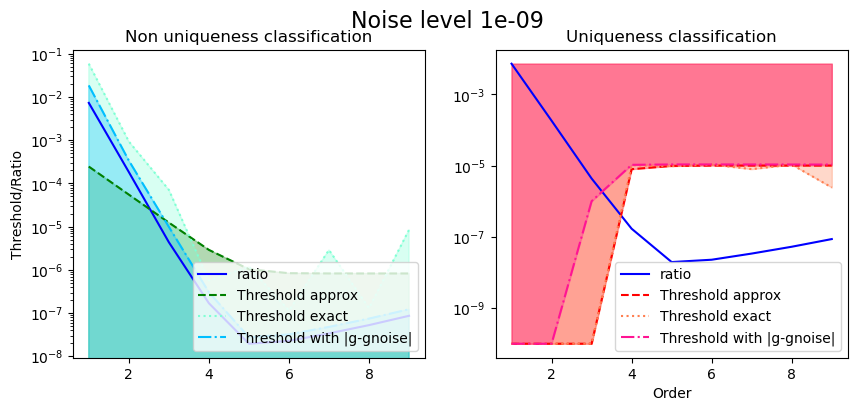

6.410445853077838e-06
order 	 singular values 	 ratio 	 Threshold uniq 	 Threshold non-uniq 
1 	 [926.01242531   6.75034474] 	 7.290e-03 	 1.000e-10 	 1.844e-02
2 	 [9.16533656e+02 1.67952914e-01] 	 1.832e-04 	 1.000e-10 	 3.376e-04
3 	 [9.16388562e+02 3.99942338e-03] 	 4.364e-06 	 1.005e-06 	 9.903e-06
4 	 [9.16393458e+02 1.92665744e-04] 	 2.102e-07 	 1.051e-05 	 3.516e-07
5 	 [9.16393579e+02 1.54473908e-04] 	 1.686e-07 	 1.063e-05 	 2.371e-07
6 	 [9.16393579e+02 1.93145351e-04] 	 2.108e-07 	 1.057e-05 	 2.981e-07
7 	 [9.16393578e+02 2.83911611e-04] 	 3.098e-07 	 1.043e-05 	 4.377e-07
8 	 [9.16393578e+02 4.38198688e-04] 	 4.782e-07 	 1.019e-05 	 6.763e-07
9 	 [9.16393577e+02 7.26756406e-04] 	 7.931e-07 	 9.748e-06 	 1.121e-06


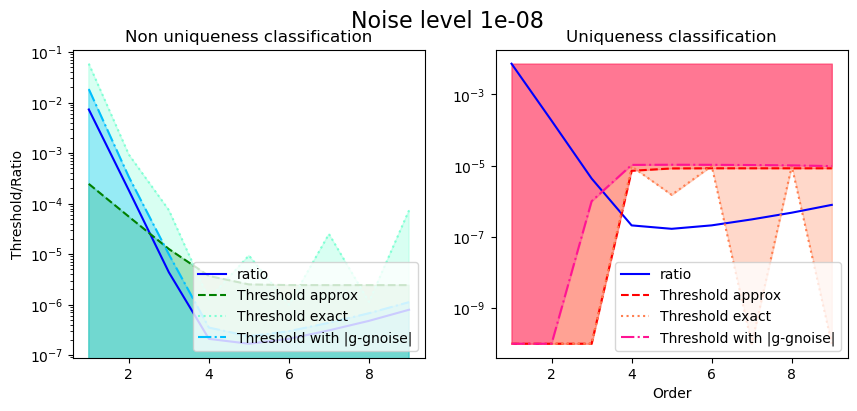

6.478434744130471e-05
order 	 singular values 	 ratio 	 Threshold uniq 	 Threshold non-uniq 
1 	 [926.01242372   6.75035075] 	 7.290e-03 	 1.000e-10 	 1.844e-02
2 	 [9.16533650e+02 1.67973998e-01] 	 1.833e-04 	 1.000e-10 	 3.376e-04
3 	 [9.16388554e+02 4.21414053e-03] 	 4.599e-06 	 7.919e-07 	 1.012e-05
4 	 [9.16393439e+02 1.15298637e-03] 	 1.258e-06 	 9.081e-06 	 1.792e-06
5 	 [9.16393539e+02 1.54003782e-03] 	 1.681e-06 	 8.512e-06 	 2.364e-06
6 	 [9.16393507e+02 1.90403209e-03] 	 2.078e-06 	 7.938e-06 	 2.940e-06
7 	 [9.16393452e+02 2.75318684e-03] 	 3.004e-06 	 6.636e-06 	 4.247e-06
8 	 [9.16393351e+02 4.18882051e-03] 	 4.571e-06 	 4.419e-06 	 6.474e-06
9 	 [9.16393171e+02 6.97385426e-03] 	 7.610e-06 	 1.327e-07 	 1.078e-05


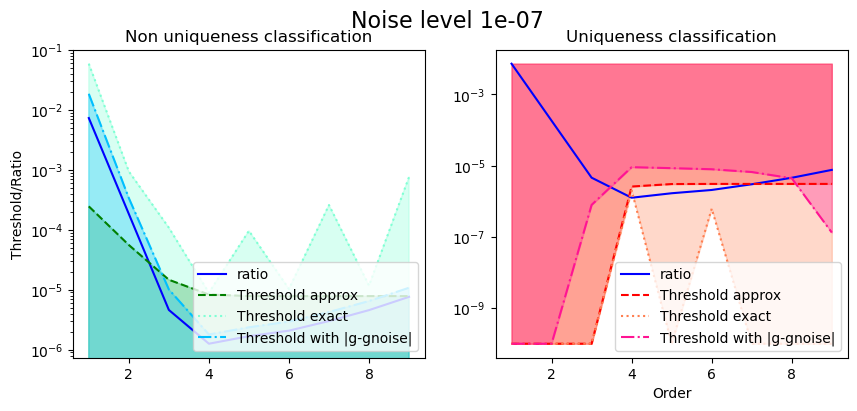

0.0006533141185759695
order 	 singular values 	 ratio 	 Threshold uniq 	 Threshold non-uniq 
1 	 [926.01246851   6.75030948] 	 7.290e-03 	 1.000e-10 	 1.844e-02
2 	 [9.16533703e+02 1.68013724e-01] 	 1.833e-04 	 1.000e-10 	 3.377e-04
3 	 [9.16388617e+02 1.25452413e-02] 	 1.369e-05 	 1.000e-10 	 2.058e-05
4 	 [9.16393549e+02 1.14125634e-02] 	 1.245e-05 	 1.000e-10 	 1.761e-05
5 	 [9.16393755e+02 1.56211287e-02] 	 1.705e-05 	 1.000e-10 	 2.398e-05
6 	 [9.16393893e+02 1.97154656e-02] 	 2.151e-05 	 1.000e-10 	 3.044e-05
7 	 [9.16394121e+02 2.92560060e-02] 	 3.193e-05 	 1.000e-10 	 4.511e-05
8 	 [9.16394506e+02 4.56403652e-02] 	 4.980e-05 	 1.000e-10 	 7.046e-05
9 	 [9.16395096e+02 7.63738444e-02] 	 8.334e-05 	 1.000e-10 	 1.179e-04


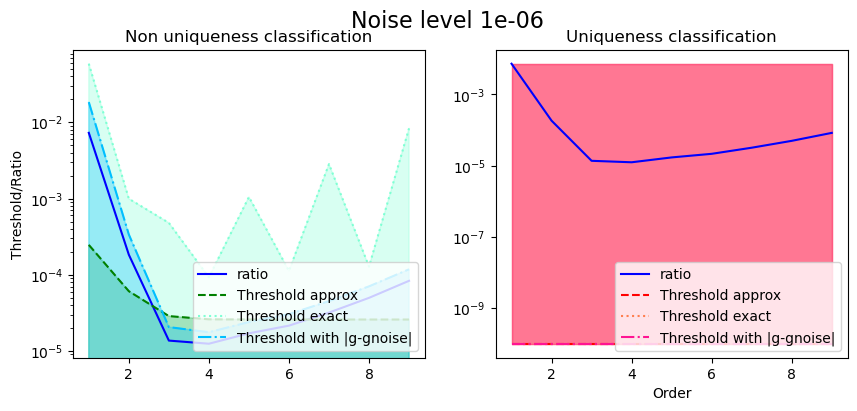

0.006457534447787886
order 	 singular values 	 ratio 	 Threshold uniq 	 Threshold non-uniq 
1 	 [926.01294016   6.75088243] 	 7.290e-03 	 1.000e-10 	 1.844e-02
2 	 [9.16534082e+02 1.81570516e-01] 	 1.981e-04 	 1.000e-10 	 3.544e-04
3 	 [9.16388911e+02 1.18639069e-01] 	 1.295e-04 	 1.000e-10 	 1.806e-04
4 	 [9.16393570e+02 1.13010381e-01] 	 1.233e-04 	 1.000e-10 	 1.745e-04
5 	 [9.16393214e+02 1.54021428e-01] 	 1.681e-04 	 1.000e-10 	 2.364e-04
6 	 [9.16392643e+02 1.92944358e-01] 	 2.105e-04 	 1.000e-10 	 2.978e-04
7 	 [9.16391904e+02 2.86967536e-01] 	 3.131e-04 	 1.000e-10 	 4.425e-04
8 	 [9.16390704e+02 4.49557550e-01] 	 4.906e-04 	 1.000e-10 	 6.942e-04
9 	 [9.16388368e+02 7.53915124e-01] 	 8.227e-04 	 1.000e-10 	 1.165e-03


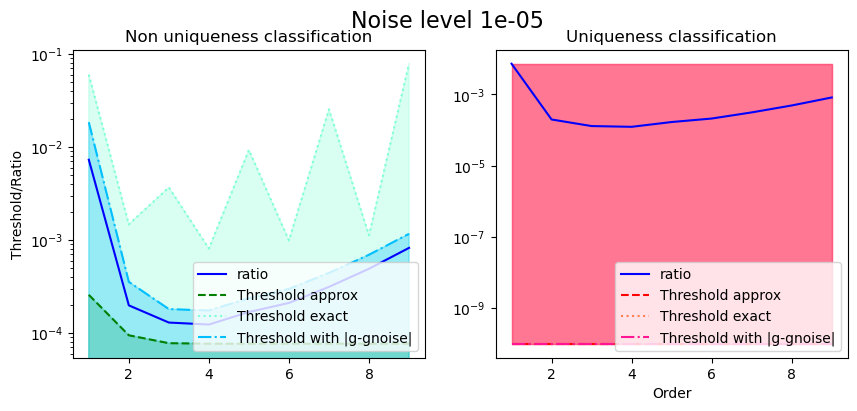

0.06477825566299591
order 	 singular values 	 ratio 	 Threshold uniq 	 Threshold non-uniq 
1 	 [926.01749433   6.86831323] 	 7.417e-03 	 1.000e-10 	 1.855e-02
2 	 [9.16537071e+02 7.43392089e-01] 	 8.111e-04 	 1.000e-10 	 1.170e-03
3 	 [916.39123613   1.19781288] 	 1.307e-03 	 1.000e-10 	 1.826e-03
4 	 [916.39265629   1.1473235 ] 	 1.252e-03 	 1.000e-10 	 1.775e-03
5 	 [916.38768881   1.55671264] 	 1.699e-03 	 1.000e-10 	 2.396e-03
6 	 [916.38323434   1.94134465] 	 2.118e-03 	 1.000e-10 	 3.006e-03
7 	 [916.38021176   2.82229825] 	 3.080e-03 	 1.000e-10 	 4.370e-03
8 	 [916.37992891   4.26878357] 	 4.658e-03 	 1.000e-10 	 6.632e-03
9 	 [916.39130088   6.95832459] 	 7.593e-03 	 1.000e-10 	 1.085e-02


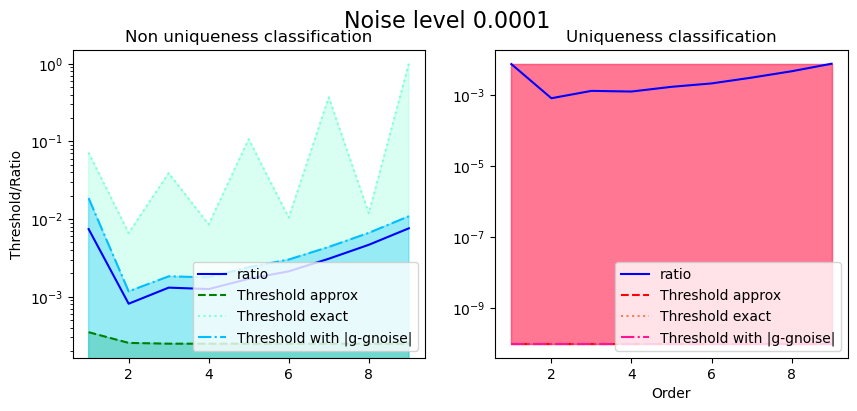

0.6538274270848623
order 	 singular values 	 ratio 	 Threshold uniq 	 Threshold non-uniq 
1 	 [926.10604606  14.64433675] 	 1.581e-02 	 1.000e-10 	 2.757e-02
2 	 [916.61108254   7.26416666] 	 7.925e-03 	 1.000e-10 	 1.134e-02
3 	 [916.53487361  12.00989187] 	 1.310e-02 	 1.000e-10 	 1.862e-02
4 	 [916.62645051  11.85501336] 	 1.293e-02 	 1.000e-10 	 1.864e-02
5 	 [916.81258555  16.48411836] 	 1.798e-02 	 1.000e-10 	 2.599e-02
6 	 [917.04256074  21.38992375] 	 2.332e-02 	 1.000e-10 	 3.418e-02
Error is too big C<eps with C = 9.164e+02, eps = 2.375e+03: no upper bound can be calculated
7 	 [917.50775712  31.35556997] 	 3.417e-02 	 1.000e-10 	 5.093e-02
8 	 [918.47659284  46.87126957] 	 5.103e-02 	 1.000e-10 	 7.841e-02
Error is too big C<eps with C = 9.164e+02, eps = 6.963e+03: no upper bound can be calculated
9 	 [920.7316398   73.58042296] 	 7.992e-02 	 1.000e-10 	 1.298e-01


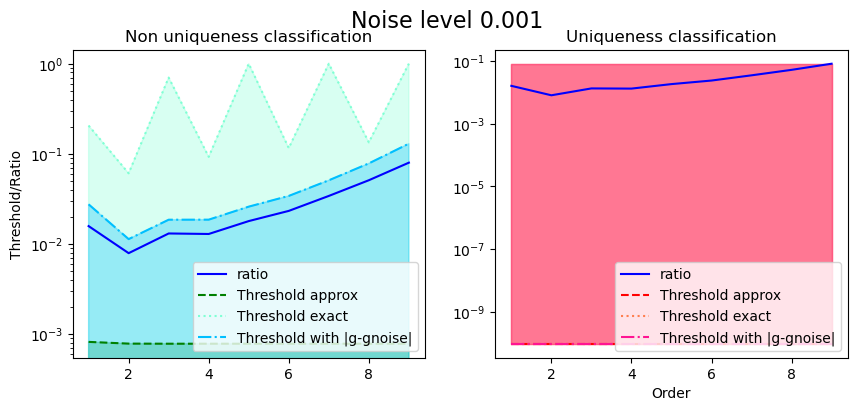

In [26]:
M=infinity_norm(uxxx)
number_noise=9 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(1,10,1)
unorm2=np.sqrt(np.mean(np.square(u)))

for target_noise in noise_levels:    
    threshold_uniq_list = []
    threshold2_uniq_list = []
    threshold3_uniq_list = []
    threshold_nonunique_list = []
    threshold2_nonunique_list = []
    threshold3_nonunique_list = []
    ratio_list=[]
    
    var = target_noise * unorm2
    noise = np.random.normal(0, var, size=u.shape)
    print(np.linalg.norm(noise))
    u_noise = u + noise
    eps_two = np.linalg.norm(u-u_noise)
    eps_infty = infinity_norm(u-u_noise)
    print(f"order \t singular values \t ratio \t Threshold uniq \t Threshold non-uniq ")
    for order in orders:        
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
        g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
        sv = svd(g_noise, compute_uv=False)
        
        
        ratio=sv[-1]/sv[0]

        #Potential upper bounds for |G-G_noise| 
        E1=np.sqrt(eps_infty/dx+dx**order)
        E2 = np.sqrt(error_bound_g(eps_two,eps_infty,dx,true_g.shape[0],M,order))
        E3 = np.linalg.norm(true_g-g_noise)
        
        threshold_uniq =  calc_threshold_uniq(C1,C2,E1)
        threshold2_uniq =  calc_threshold_uniq(C1,C2,E2)
        threshold3_uniq =  calc_threshold_uniq(C1,C2,E3)
        threshold_uniq_list.append(threshold_uniq)
        threshold2_uniq_list.append(threshold2_uniq)
        threshold3_uniq_list.append(threshold3_uniq)

  
        threshold_nonunique = calc_threshold_nonuniq(E1,C)
        threshold2_nonunique = calc_threshold_nonuniq(E2,C)
        threshold3_nonunique = calc_threshold_nonuniq(E3,C)
        threshold_nonunique_list.append(threshold_nonunique)
        threshold2_nonunique_list.append(threshold2_nonunique)
        threshold3_nonunique_list.append(threshold3_nonunique)
        
        print(f"{order} \t {sv} \t {ratio:.3e} \t {threshold3_uniq:.3e} \t {threshold3_nonunique:.3e}")
        ratio_list.append(ratio)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
    fig.suptitle(f'Noise level {target_noise}', fontsize=16)
    
    # Subplot 1: ratio and green lines
    ax1.set_title("Non uniqueness classification")
    ax1.plot(orders, ratio_list, label='ratio', color='blue')
    ax1.plot(orders, threshold_nonunique_list, '--', label='Threshold approx', color='green')
    ax1.plot(orders, threshold2_nonunique_list, ':', label='Threshold exact', color='aquamarine')
    ax1.plot(orders, threshold3_nonunique_list, '-.', label='Threshold with |g-gnoise|', color='deepskyblue')
    ax1.fill_between(orders, threshold_nonunique_list, color='green', alpha=0.3)
    ax1.fill_between(orders, threshold2_nonunique_list, color='aquamarine', alpha=0.3)
    ax1.fill_between(orders, threshold3_nonunique_list, color='deepskyblue', alpha=0.3)
    ax1.set_yscale('log')
    ax1.set_ylabel('Threshold/Ratio')
    
    # Subplot 2: ratio and red lines
    ax2.set_title("Uniqueness classification")
    ax2.plot(orders, ratio_list, label='ratio', color='blue')
    ax2.plot(orders, threshold_uniq_list, '--', label='Threshold approx', color='red')
    ax2.plot(orders, threshold2_uniq_list, ':', label='Threshold exact', color='coral')
    ax2.plot(orders, threshold3_uniq_list, '-.', label='Threshold with |g-gnoise|', color='deeppink')
    ax2.fill_between(orders, threshold_uniq_list, y2=np.max(ratio_list), color='red', alpha=0.3)
    ax2.fill_between(orders, threshold2_uniq_list, y2=np.max(ratio_list), color='coral', alpha=0.3)
    ax2.fill_between(orders, threshold3_uniq_list, y2=np.max(ratio_list), color='deeppink', alpha=0.3)
    ax2.set_yscale('log')

    
    ax2.set_xlabel('Order')
    ax1.legend(loc=4)
    ax2.legend(loc=4)
    
    plt.show()
    